In [1]:
%pylab inline
# next 2 lines allow to automatically reload modules that have been changed externally
%reload_ext autoreload
%autoreload 2
import os, sys
sys.path.insert(0, '/nobackup/jakravit/smartg-dev/smartg/')
from luts.luts import LUT, MLUT, Idx, merge, read_mlut

from smartg.albedo import Albedo_spectrum, Albedo_speclib, Albedo_cst
from smartg.bandset import BandSet
from smartg.smartg import Smartg, Sensor, multi_profiles, reduce_diff
from smartg.smartg import RoughSurface, LambSurface, FlatSurface, Environment, multi_profiles
from smartg.atmosphere import AtmAFGL, AeroOPAC, CompOPAC, CloudOPAC, diff1, read_phase, Species, trapzinterp
from smartg.water import IOP_1, IOP, IOP_profile, IOP_Rw, IOP_base
from smartg.reptran import REPTRAN, reduce_reptran
#from smartg.kdis import KDIS, reduce_kdis
from smartg.tools.tools import SpherIrr, Irr, reduce_Irr
from smartg.tools.cdf import ICDF
from smartg.tools.phase import integ_phase, calc_iphase

from smartg.tools.smartg_view import compare, plot_polar, spectrum , mdesc 
from smartg.tools.smartg_view import spectrum_view,transect_view,profile_view,phase_view,smartg_view,input_view
import warnings

from scipy.interpolate import interp1d
warnings.filterwarnings("ignore")

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pickle
INFO = True
WAV = np.linspace(400, 900., num=201, dtype=np.float32)
WAV_CDOM = np.arange(240., 900., 2.5, dtype=np.float32)

# initiate iop dict
# iops, cols, row = build_Case2(phy_library, datamin, datadet, benthic_lib, adj_lib, aero_lib)
with open('/nobackup/jakravit/data/iops_test.p','rb') as fp:
    iops_case2 = pickle.load(fp)

with open('/nobackup/jakravit/data/case1_runlist.p','rb') as fp:
    case1 = pickle.load(fp)

runID1 = '0.563_0.015_0.033_0.032_FShk4FqxnG'
iops_case1 = case1[runID1]    

if INFO:
    print ('CASE 1 INFO:')
    print ('Chla: {} ug/L'.format(iops_case1['Phyto']['TotChl']))
    print ('Minl: {} g/L'.format(iops_case1['Min']['tot_conc']))
    print ('ag440: {} m^-1'.format(iops_case1['CDOM']['a_tot'][80]))
    print ('\nCASE 2 INFO:')
    print ('Chla: {} ug/L'.format(iops_case2['Phyto']['TotChl']))
    print ('Minl: {} g/L'.format(iops_case2['Min']['Tot_conc']))
    print ('ag440: {} m^-1'.format(iops_case2['CDOM']['ag440']))
    # print ('Max Depth: {} m'.format(iops_case1['Depth']['Dmax']))
    # print ('Water radius: {} km'.format(iops_case1['Adjacency']['water_radius']))
    # print ('Dist from shore: {} km'.format(iops_case1['Adjacency']['dist']))

CASE 1 INFO:
Chla: 0.563 ug/L
Minl: 0.014625739628414677 g/L
ag440: 0.08964525121529826 m^-1

CASE 2 INFO:
Chla: 12.062 ug/L
Minl: 3.1160428571428573 g/L
ag440: 1.16 m^-1


In [3]:
from smartg_int_library import *

# get mixing IOP's
ap1,ac1,bp1,vsf1,angles = mix(iops_case1)
ap2,ac2,bp2,vsf2,angles = mix(iops_case2)

# wavelength grid/slice for absorption and scattering coefficients
# wavelength grid for outputs
wavrange = slice(0,200,5)
wav      = WAV[wavrange]
# wavelength grid/slice for scattering matrices
wavrange_vsf = slice(0,200,50)
wav_vsf      = WAV[wavrange_vsf]
# vertical grid
Z   = np.array([0, -10, -25., -50.])
zeros=np.zeros_like(wav)

#IOP's profiles
# case 1 lists
vsf_list1=[vsf1[:,wavrange_vsf,:], vsf1[:,wavrange_vsf,:], vsf1[:,wavrange_vsf,:], vsf1[:,wavrange_vsf,:] ]
bp_list1 = [zeros, bp1[wavrange], bp1[wavrange], bp1[wavrange]]
ap_list1 = [zeros, ap1[wavrange], ap1[wavrange], ap1[wavrange]]
ac_list1 = [zeros, ac1[wavrange], ac1[wavrange], ac1[wavrange]]
#aw_list = [zeros, ww['aw'], ww['aw'], ww['aw']] 
#bw_list = [zeros, ww['bw'], ww['bw'], ww['bw']] 
aw_list = None # use SMART-G default pure water absorption
bw_list = None # use SMART-G default pure water scattering

# case 2 lists
vsf_list2=[vsf2[:,wavrange_vsf,:], vsf2[:,wavrange_vsf,:], vsf2[:,wavrange_vsf,:], vsf2[:,wavrange_vsf,:] ]
bp_list2 = [zeros, bp2[wavrange], bp2[wavrange], bp2[wavrange]]
ap_list2 = [zeros, ap2[wavrange], ap2[wavrange], ap2[wavrange]]
ac_list2 = [zeros, ac2[wavrange], ac2[wavrange], ac2[wavrange]]

# Albedos speclib library inputs
Type = ['Sand', 'Forest']
ALB = [Albedo_speclib('/nobackup/jakravit/data/albedos/rock.sedimentary.sandstone.fine.all.sandstone_7.jhu.becknic.spectrum.txt'),
       Albedo_speclib('/nobackup/jakravit/data/albedos/vegetation.tree.betula.lenta.vswir.bele-1-55.ucsb.asd.spectrum.txt')]

# dirspec = '/rfs/data/speclib2.0/data/'
# Type    = ['Forest', 'Bare soil', 'Grass', 'Snow', 'Sand']
# ALB     = [Albedo_speclib(dirspec+'jhu.becknic.vegetation.trees.deciduous.solid.decidou.spectrum.txt'),
#            Albedo_speclib(dirspec+'jhu.becknic.soil.alfisol.paleustalf.coarse.87P473.spectrum.txt'),
#            Albedo_speclib(dirspec+'jhu.becknic.vegetation.grass.green.solid.gras.spectrum.txt'),
#            Albedo_speclib(dirspec+'jhu.becknic.water.snow.granular.82um.medium.spectrum.txt'),
#            Albedo_speclib(dirspec+'jhu.becknic.rock.sedimentary.sandstone.fine.sandst7.spectrum.txt')]

# water MLUT building
# VSF truncation at 25 deg
# seafloor Sand albedo
water1   = import_iop(ap_list1, bp_list1, ac_list1, vsf_list1, wav, wav_vsf, Z, angles, 
                    aw_list=aw_list, bw_list=bw_list, ang_trunc=25.,  )

water2   = import_iop(ap_list2, bp_list2, ac_list2, vsf_list2, wav, wav_vsf, Z, angles, 
                    aw_list=aw_list, bw_list=bw_list, ang_trunc=25.,  ALB=ALB[0])


## Comments on Inputs
- Why is the first entry for VSF list non-zero, where bp, ap, ac lists are zero?
- Getting "AttributeError: 'MLUT' object has no attribute 'calc' (removed and seems to still work fine...)

In [4]:
# Goal: to simulate an observation from a satellite sensor 
# for 1 thv and 1 azimuth
# with a straight coastline (limit ocean land at x=0, ocean for x <0)
# the sensor is looking to a water pixel located at a distance 'dist' from the coastline
# we simulate a coastline as being the zone near a big circle, whose radius is 1e6 km
# centred on a point located far from the sensor (-1e6 km from the origin )
# The interior of the circle is the ocean

# Ocean surface
surf=RoughSurface(WAVE_SHADOW=True, WIND=12.)

# Land environment
D       = 1.0e6 #(km)
# The Environement object creates a disk of ocean surface with radius ENV_SIZE
# centred on X0,Y0 , surrounded by lambertian reflector of albedo ALB
env     = Environment(ENV=1, 
                  ENV_SIZE= D ,       # radius of the circle with ocean surface condition
                  X0= -D,             # X coordinate of the center of the circle
                  Y0= 0,
                  ALB=ALB[1] # Lambertian grey albedo of the land zone (forest)
                 )
#Observer
HTOA   = 120.
VZA    = 30.
VAA    = 90.
dist   = 1 # distance to the coast(km)
DeltaH = HTOA   * np.tan(np.radians(VZA))
DeltaX = DeltaH * np.cos(np.radians(180-VAA))
DeltaY = DeltaH * np.sin(np.radians(180-VAA))
sensor_TOA = Sensor(
    POSX = -dist + DeltaX,      # Sensor coordinates (in km) (default:origin(0.,0.,0.))
    POSY = DeltaY,
    POSZ = HTOA,
    THDEG= 180-VZA, # Sensor 'Emitting' zenith angle, from 0: Zenith to 180.: Nadir (default:0.)
    PHDEG= VAA,     # Sensor 'Emitting' azimuth angle (default:0.)
    LOC  = 'ATMOS', # location of sensor (default: (SURF0P, just above surface)
    FOV  = 0.,      # Sensor FOV (default 0.)
    TYPE = 0        # Sensor type :Radiance (0), Planar flux (1), Spherical Flux (2), (default 0)
    )
sensor_BOA = Sensor(THDEG=180-VZA, PHDEG=VAA, TYPE=0, LOC='ATMOS')

# Atmosphere
# to be computed at eh same wavlegnth grid as water IOP's
atm = AtmAFGL('afglt', comp=[AeroOPAC('continental_average', 0.2, 550)], pfwav=wav_vsf).calc(wav)

In [5]:
# Backward Local Estimate -> Solar geometries
#le  = {'th_deg':np.linspace(0,85,num=12), 'phi_deg':np.linspace(0,360,num=18)}
le = {'th_deg':np.linspace(30,60,num=2), 'phi_deg':np.linspace(0,360,num=4)}
alis = True
alis_options = {'nlow':-1}
SMa = Smartg(device=0, back=True, alt_pp=True, alis=alis)
SM  = Smartg(device=0, back=True, alt_pp=True)

In [6]:
%%time
# case1 water w/ alis and adjacency
mBc1env  = SMa.run(wl=wav, water=water1, atm=atm, surf=surf, NBPHOTONS=1e4, env=env,
                   sensor=sensor_TOA, NF=1e3, alis_options=alis_options, le=le, RR=1, WEIGHTRR=.01, OUTPUT_LAYERS=3)


# case1 water w/ alis and no adjacency
mBc1  = SMa.run(wl=wav, water=water1, atm=atm, surf=surf, NBPHOTONS=1e4,
                   sensor=sensor_TOA, NF=1e3, alis_options=alis_options, le=le, RR=1, WEIGHTRR=.01, OUTPUT_LAYERS=3)


# case2 water w/ alis and adjacency
mBc2env  = SMa.run(wl=wav, water=water2, atm=atm, surf=surf, NBPHOTONS=1e4, env=env,
                   sensor=sensor_TOA, NF=1e3, alis_options=alis_options, le=le, RR=1, WEIGHTRR=.01, OUTPUT_LAYERS=3)


# case2 water w/ alis and no adjacency
mBc2  = SMa.run(wl=wav, water=water2, atm=atm, surf=surf, NBPHOTONS=1e4,
                   sensor=sensor_TOA, NF=1e3, alis_options=alis_options, le=le, RR=1, WEIGHTRR=.01, OUTPUT_LAYERS=3)

Box(children=(FloatProgress(value=0.0, max=10000.0), Label(value='')), layout=Layout(align_items='center', dis…

Box(children=(FloatProgress(value=0.0, max=10000.0), Label(value='')), layout=Layout(align_items='center', dis…

Box(children=(FloatProgress(value=0.0, max=10000.0), Label(value='')), layout=Layout(align_items='center', dis…

Box(children=(FloatProgress(value=0.0, max=10000.0), Label(value='')), layout=Layout(align_items='center', dis…

CPU times: user 45 s, sys: 35.2 s, total: 1min 20s
Wall time: 1min 21s


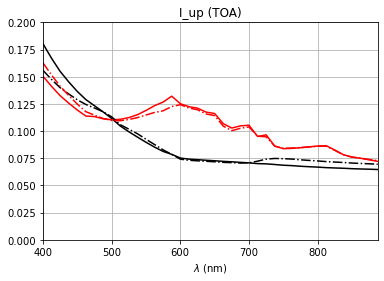

In [7]:
## compare case1 and case2 no ENV at TOA

lut1 = mBc1 ['I_up (TOA)'].sub({'Zenith angles':Idx(30), 'Azimuth angles':Idx(90)})
lut2 = mBc2['I_up (TOA)'].sub({'Zenith angles':Idx(30), 'Azimuth angles':Idx(90)})
lut3 = mBc1env ['I_up (TOA)'].sub({'Zenith angles':Idx(30), 'Azimuth angles':Idx(90)})
lut4 = mBc2env['I_up (TOA)'].sub({'Zenith angles':Idx(30), 'Azimuth angles':Idx(90)})

f = figure()
spectrum(lut1, vmin=0, vmax=.2, sub=111,  fig=f, color='k', percent=False, fmt='-') # case1
spectrum(lut2, vmin=0, vmax=.2, sub=None, fig=f, color='r', percent=False, fmt='-') # case2
spectrum(lut3, vmin=0, vmax=.2, sub=None,  fig=f, color='k', percent=False, fmt='-.') # case1 adjacency
spectrum(lut4, vmin=0, vmax=.2, sub=None, fig=f, color='r', percent=False, fmt='-.') # case2 adjacency

## Comments on TOA reflectance

- The case1 spectra look reasonable both with and without adjacency
- The case2 spectra with adjacency has a large spike around 580nm that doesn't look normal

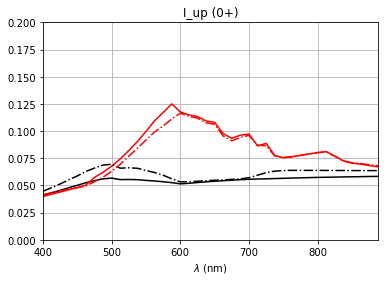

In [8]:
## compare case1 and case2 no ENV at BOA

lut1 = mBc1 ['I_up (0+)'].sub({'Zenith angles':Idx(30), 'Azimuth angles':Idx(90)})
lut2 = mBc2['I_up (0+)'].sub({'Zenith angles':Idx(30), 'Azimuth angles':Idx(90)})
lut3 = mBc1env ['I_up (0+)'].sub({'Zenith angles':Idx(30), 'Azimuth angles':Idx(90)})
lut4 = mBc2env['I_up (0+)'].sub({'Zenith angles':Idx(30), 'Azimuth angles':Idx(90)})

f = figure()
spectrum(lut1, vmin=0, vmax=.2, sub=111,  fig=f, color='k', percent=False, fmt='-') # case1
spectrum(lut2, vmin=0, vmax=.2, sub=None, fig=f, color='r', percent=False, fmt='-') # case2
spectrum(lut3, vmin=0, vmax=.2, sub=None,  fig=f, color='k', percent=False, fmt='-.') # case1 adjacency
spectrum(lut4, vmin=0, vmax=.2, sub=None, fig=f, color='r', percent=False, fmt='-.') # case2 adjacency

## Comments on BOA reflectance

- Shouldn't water leaving reflectance not be affected by adjacency, as the contribution should solely be due to upwelling radiance?? 
- Similar abnormal spike around 580nm in the adjacency LUT for case2. 
- It also seems the red/NIR region is too high compared to the blue. Especially the case1 spectra should have much higher values in the blue than NIR. Is water taken into account well enough?